In [65]:
import os
from gensim.models import KeyedVectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import f1_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import tqdm
from collections import Counter
from langdetect import detect

Побудуйте класифікатор, який буде предбачати категорію запиту до служби 1551 з використанням тільки векторів слів (не використовувати інших фічі, такі як самі слова, нграми і т.д).

## Data loading and preprocessing

In [2]:
model = KeyedVectors.load_word2vec_format('word2vec', binary=False)
model.init_sims(replace=True)

In [3]:
class FileParser:
    def __init__(self):
        self.documents = []
        self.state = "empty"
        self.current = {}
    
    def process_line(self, line, category):
        if line.strip().isnumeric():
            self.state = "id"
            self.current['id'] = line.strip().lower()
        elif self.state == "id" or (self.state == 'text' and line != '\n'):
            self.state = 'text'
            current_text = self.current.get("text", "")
            self.current['text'] = current_text + line.lower().replace("\n", " ")
        elif line == '\n' and self.state != 'newline':
            self.state = 'newline'
        elif line == '\n' and self.state == 'newline':
            self.state = "empty"
            self.current['category'] = category
            self.documents.append(self.current)
            self.current = {}
            

In [4]:
# Parsing txt files
DATA_PATH = "data"
parser = FileParser()
for file_name in tqdm.tqdm_notebook(os.listdir(DATA_PATH)):
    category = file_name.split(".")[0]
    with open(f"{DATA_PATH}/{file_name}", encoding='utf-8', errors='ignore') as file:  
        for line in file:
            parser.process_line(line, category)

In [5]:
documents = parser.documents
categories = {doc['category'] for doc in documents}

In [7]:
def valid_doc(doc):
    contains_text = "text" in doc
    if contains_text:
        try:
            is_uk = detect(doc['text']) == 'uk'
            return is_uk
        except:
            print(f"Can't detect lang for text: {doc['text']}")
            return False
    
    return contains_text

#Filter not relevant documents
documents = [doc for doc in tqdm.tqdm_notebook(documents) if valid_doc(doc)]

Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang: з 1 грудня у нашому будинку не працює домофонна система (не зачиняються двері), послуги надає компанія цифрал-сервіс. неодноразові телефонні звернення результатів не дають. внаслідок цієї ситуації, за інформацією компаннії отіс, в нашому будинку було викрадено ліфтове обладнання, 5 грудня не працювали обидва ліфти. на разі не працює один ліфт. крім того, не замикано на замок вихід на горище, що в комплексі дало можливість викрадачам зняти відповідне обладнання. ми вимушені користуватись сходовими клітинами, які не прибрані. зважаючи на викладене прошу звернутись до компаннії цифрал-сервіс з питання забезпечення ремонту домофонної системи. 
Can't detect lang:

Can't detect lang: 3) 
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang: 18.10 
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang: 1) 
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang:  
Can't detect lang: 27.11.2014, 00:23  
Can't d

In [72]:
class Vectorizer:
    def __init__(self, w2v, stopwords):
        self.w2v = w2v
        self.stopwords = stopwords
    
    def vectorize_text(self, text):
        result = np.zeros((300))
        vectors = []
        for word in text.split(" "):
            if word in self.w2v and word not in self.stopwords and len(word) > 0:
                vector = self.w2v.get_vector(word)
                result += vector
                vectors.append(vector)
        return result, vectors


In [73]:
label_encoder = LabelEncoder().fit(list(categories))
vectorizer = Vectorizer(model, [])
for doc in tqdm.tqdm_notebook(documents):
    aggregated_vector, vectors = vectorizer.vectorize_text(doc['text'])
    doc['vector'] = aggregated_vector
    doc['word_vector'] = vectors
    doc['y'] = label_encoder.transform([doc['category']])[0]
    

In [74]:
X = documents
labels = [doc['y'] for doc in documents]
train, test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.3)

In [75]:
x_train = [x['vector'] for x in train]
x_test = [x['vector'] for x in test]

## Task 1

Можете використайте фільтрацію мови, щоб відібрати тільки україномовні запити.


1. У якості безйлайну використайте класифікатор kNN, який буде шукати найближчі за косинусною відстанню вектори запитів, утворені сумуванням векторів всіх слів запиту.

In [77]:
neigh = NearestNeighbors(1, n_jobs=-1, metric='cosine')
neigh.fit(x_train, y_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=1, p=2, radius=1.0)

In [78]:
predicted = neigh.kneighbors(x_test, 1, return_distance=False)

In [79]:
y_predicted = np.array(y_train)[predicted].reshape(-1)

In [97]:
f1_w, f1_m = f1_score(y_test, y_predicted, average='weighted'), f1_score(y_test, y_predicted, average='macro')
print(f"F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

F1 weighted: 0.379 | F1 macro: 0.292


## Task 2

2. Розробіть покращений класифікатор, для якого використайте іншу модель класифікації, яка би присвоювала ваги окремим елементам вектора (наприклад, Logistic Regression, SVM, Random Forest). Також можете зробити додаткові покращення, такі як:

  - здійснювати попередню фільтрацію і відбирати тільки частину векторів для представлення

  - використовувати лематизацію та інші форми нормалізації

  - робити зваження векторів

  - додатково використовувати інші способи побудувати вектор документу (наприклад, TF-IDF, LDA, ...)

In [102]:
from sklearn.linear_model import SGDClassifier

In [147]:
%%time
linear = SGDClassifier(loss='log', alpha=0.000001, penalty='l1',
                       max_iter=50, random_state=42, n_jobs=-1,
                       verbose=0).fit(x_train, y_train)

CPU times: user 19min 6s, sys: 2.66 s, total: 19min 8s
Wall time: 5min 3s


/Users/sasha/programming/edu/ucu/nlp/.env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [148]:
logreg_predict = linear.predict(x_test)
f1_w, f1_m = f1_score(y_test, logreg_predict, average='weighted'), f1_score(y_test, logreg_predict, average='macro')
print(f"Test Score | F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

Test Score | F1 weighted: 0.425 | F1 macro: 0.349


### Removing stopwords from text

In [168]:
with open("uk-stopwords.txt") as f:
    stopwords = f.read().split("\n")

In [169]:
label_encoder = LabelEncoder().fit(list(categories))
vectorizer = Vectorizer(model, stopwords)
for doc in tqdm.tqdm_notebook(documents):
    aggregated_vector, vectors = vectorizer.vectorize_text(doc['text'])
    doc['vector'] = aggregated_vector
    doc['word_vector'] = vectors
    doc['y'] = label_encoder.transform([doc['category']])[0]
    

In [170]:
X = documents
labels = [doc['y'] for doc in documents]
train, test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.3)

In [171]:
x_train = [x['vector'] for x in train]
x_test = [x['vector'] for x in test]

### Running classifier again

In [172]:
%%time
linear = SGDClassifier(loss='log', alpha=0.000001, penalty='l1',
                       max_iter=10, random_state=42, n_jobs=-1,
                       verbose=0).fit(x_train, y_train)

CPU times: user 4min 26s, sys: 672 ms, total: 4min 27s
Wall time: 1min 10s


/Users/sasha/programming/edu/ucu/nlp/.env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [173]:
logreg_predict = linear.predict(x_test)
f1_w, f1_m = f1_score(y_test, logreg_predict, average='weighted'), f1_score(y_test, logreg_predict, average='macro')
print(f"Test Score | F1 weighted: {f1_w:.3} | F1 macro: {f1_m:.3}")

Test Score | F1 weighted: 0.422 | F1 macro: 0.347


## Task 3

3. Розробіть класифікатор на основі нейромережі: або feed-forward з використанням агрегованого вектору, або LSTM (чи BiLSTM), що проходить по всьому тексту. 

In [174]:
import torch
import torch.nn as nn
from torch.utils import data
from torch.functional import F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_sequence

In [184]:
# Pad batch to the same seq len
def padding_collate(batch):
    data = [item[0] for item in batch]
    data = pad_sequence(data, batch_first=True)
    targets = torch.cat([item[1] for item in batch])
    return [data, targets]

class DataLoader(data.Dataset):
    def __init__(self, data, max_len=50):
        self.data = [doc for doc in data if len(doc['word_vector']) > 1]
        self.max_len=max_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        doc = self.data[idx]
        vector = np.array(doc['word_vector'])[:self.max_len]
        label = doc['y']
        return torch.from_numpy(vector).float(), torch.from_numpy(np.array([label])).long()

In [244]:
class Trainer:
    def __init__(self, net, config, lr=0.001, l2_rate=0):
        net.train()
        net.to(config['DEVICE'])
        self.device = config['DEVICE']
        self.net = net
        self.config = config
        self.optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=l2_rate)
        self.loss = nn.CrossEntropyLoss()
        self.losses = []

    def run(self, dataloader, epochs=1):
        print(">> Running trainer")
        for epoch in range(epochs):
            print(">>> Epoch %s" % epoch)
            for idx, (vectors, target) in enumerate(tqdm.tqdm_notebook(dataloader, ascii=True)):
                vectors, target = vectors.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                predict = self.net(vectors)
                loss = self.loss(predict, target)
                loss.backward()
                self.losses.append(loss.item())
                self.optimizer.step()
                if idx % 50 == 0:
                    print(">>> Loss: {}".format(np.mean(self.losses[-10:])))

                if self.config['DEBUG'] == True:
                    break
            print("Trainer epoch finished")


In [245]:
class Evaluation:
    def __init__(self, net, config):
        net.eval()
        net.to(config['DEVICE'])
        self.device = config['DEVICE']
        self.net = net
        self.config = config
        self.loss = nn.CrossEntropyLoss()

    def run(self, dataloader):
        print(">> Running Evaluation")
        predicted = []
        labels = []
        with torch.no_grad():
            for idx, (image, target) in enumerate(tqdm.tqdm_notebook(dataloader, ascii=True)):
                image, target = image.to(self.device), target.to(self.device)
                predict = self.net(image)
                pred = F.softmax(predict, 1).argmax(dim=1, keepdim=True)
                predicted.extend(list(pred.numpy()))
                labels.extend(list(target.view_as(pred).numpy()))
                if self.config['DEBUG'] == True:
                    break

        print("Evaluation finished")
        return {
            'f1_weighted': f1_score(labels, predicted, average='weighted'),
            'f1_macro': f1_score(labels, predicted, average='macro')

        }

In [283]:
class Network(nn.Module):
    def __init__(self, categories_count):
        super(Network,self).__init__()
        hidden_size = 50
        self.lstm = nn.LSTM(input_size=300, hidden_size=hidden_size, batch_first=True,
                            num_layers=1, bidirectional=False)
        self.linear = nn.Linear(hidden_size * 3, categories_count)
    
    def forward(self, input):
        out, (h0, c0) = self.lstm(input)
        out = out[:, -1:, :].transpose(0, 1)
        out = torch.cat((out, h0, c0), 2)[0]
        out = self.linear(F.relu(out))
        return out

In [284]:
config = {
    'DEBUG': False,
    'CUDA': torch.cuda.is_available(),
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

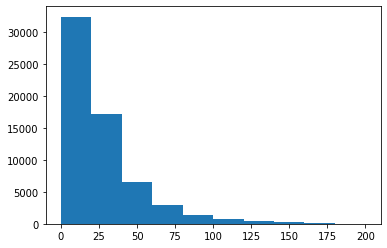

In [285]:
vectors_lens = np.array([len(doc['word_vector']) for doc in documents])
#Value that can be used as upper limit for LSTM seq len
seq_len = int(np.quantile(vectors_lens, .90))
# Number of vector counts per document (distribution) 
_ = plt.hist(vectors_lens)

In [286]:
net = Network(len(categories))

In [287]:
train_data = DataLoader(train, max_len=seq_len)
test_data = DataLoader(test, max_len=seq_len)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=2, shuffle=False, collate_fn=padding_collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=2, shuffle=False, collate_fn=padding_collate)

In [288]:
trainer = Trainer(net, config, lr=0.01, l2_rate=1e-5)
evaluation = Evaluation(net, config)

In [289]:
for i in range(5):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 5.260350704193115
>>> Loss: 4.504076099395752
>>> Loss: 4.4239565372467045
>>> Loss: 4.38068037033081
>>> Loss: 4.391381120681762
>>> Loss: 4.402788925170898
>>> Loss: 4.3580022096633915
>>> Loss: 4.372161436080932
>>> Loss: 4.329658365249633
>>> Loss: 4.2604481220245365
>>> Loss: 4.431125545501709
>>> Loss: 4.480238056182861
>>> Loss: 4.403949642181397
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.03493522221036533, 'f1_macro': 0.003809909231563581}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.03482106335723787, 'f1_macro': 0.0037509321926584454}
>> Running trainer
>>> Epoch 0


>>> Loss: 4.27941861152649
>>> Loss: 3.9818229198455812
>>> Loss: 3.8554938316345213
>>> Loss: 3.689124584197998
>>> Loss: 3.692984437942505
>>> Loss: 3.575806450843811
>>> Loss: 3.4685685873031615
>>> Loss: 3.38601815700531
>>> Loss: 3.3947025537490845
>>> Loss: 3.1277458906173705
>>> Loss: 3.02708580493927
>>> Loss: 3.0171870231628417
>>> Loss: 2.953862500190735
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.24466104426193322, 'f1_macro': 0.050704275288567066}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.24244645133033838, 'f1_macro': 0.04863882345330198}
>> Running trainer
>>> Epoch 0


>>> Loss: 2.6964094161987306
>>> Loss: 2.705726456642151
>>> Loss: 2.6604482650756838
>>> Loss: 2.5717430830001833
>>> Loss: 2.6618427276611327
>>> Loss: 2.542675280570984
>>> Loss: 2.481380295753479
>>> Loss: 2.438708758354187
>>> Loss: 2.5428693294525146
>>> Loss: 2.3473293781280518
>>> Loss: 2.3974022388458254
>>> Loss: 2.3863854885101317
>>> Loss: 2.398568105697632
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.3491446796729237, 'f1_macro': 0.12515082334284539}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.3356487786383236, 'f1_macro': 0.11674976237460212}
>> Running trainer
>>> Epoch 0


>>> Loss: 2.1567931056022642
>>> Loss: 2.194332849979401
>>> Loss: 2.214207148551941
>>> Loss: 2.252085828781128
>>> Loss: 2.3715344071388245
>>> Loss: 2.170834982395172
>>> Loss: 2.1421743035316467
>>> Loss: 2.151401364803314
>>> Loss: 2.236175203323364
>>> Loss: 2.0609777569770813
>>> Loss: 2.131549608707428
>>> Loss: 2.1230246663093566
>>> Loss: 2.1223384737968445
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.4040537316051924, 'f1_macro': 0.1778776086289729}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.3812505688936032, 'f1_macro': 0.16105176830108706}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.933452546596527
>>> Loss: 1.9688463926315307
>>> Loss: 2.0239168047904967
>>> Loss: 2.032167136669159
>>> Loss: 2.162684404850006
>>> Loss: 1.9977168560028076
>>> Loss: 1.9297441959381103
>>> Loss: 1.9874961137771607
>>> Loss: 2.069981336593628
>>> Loss: 1.922653603553772
>>> Loss: 1.983115792274475
>>> Loss: 1.9713904976844787
>>> Loss: 1.993906605243683
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.4431475069972119, 'f1_macro': 0.21965398856128684}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.40935677457482167, 'f1_macro': 0.18825361883830985}


In [290]:
trainer = Trainer(net, config, lr=0.001, l2_rate=1e-5)
evaluation = Evaluation(net, config)
for i in range(20):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 1.961235761642456
>>> Loss: 1.7989813566207886
>>> Loss: 1.8217131733894347
>>> Loss: 1.8259228587150573
>>> Loss: 1.8666045308113097
>>> Loss: 1.7520137310028077
>>> Loss: 1.7398601055145264
>>> Loss: 1.7499449491500854
>>> Loss: 1.812553298473358
>>> Loss: 1.6954295635223389
>>> Loss: 1.7107745170593263
>>> Loss: 1.6503387689590454
>>> Loss: 1.575173032283783
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.49102521482924216, 'f1_macro': 0.26912458956264346}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.44576610586159165, 'f1_macro': 0.22162051495404939}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.6025476992130279
>>> Loss: 1.6980728149414062
>>> Loss: 1.7492130517959594
>>> Loss: 1.7535252451896668
>>> Loss: 1.8063598036766053
>>> Loss: 1.6757735013961792
>>> Loss: 1.6649932742118836
>>> Loss: 1.695382308959961
>>> Loss: 1.765053653717041
>>> Loss: 1.6396760821342469
>>> Loss: 1.6743486166000365
>>> Loss: 1.6084081888198853
>>> Loss: 1.5549994707107544
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5010393497697457, 'f1_macro': 0.2850596732158345}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.45118739768673904, 'f1_macro': 0.23064106160974004}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.5758160471916198
>>> Loss: 1.6548134207725524
>>> Loss: 1.711310040950775
>>> Loss: 1.7140814900398254
>>> Loss: 1.771048903465271
>>> Loss: 1.628561758995056
>>> Loss: 1.6272199153900146
>>> Loss: 1.662140679359436
>>> Loss: 1.7358387470245362
>>> Loss: 1.6039551496505737
>>> Loss: 1.649101150035858
>>> Loss: 1.578217053413391
>>> Loss: 1.5325187206268311
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5112602010211649, 'f1_macro': 0.2988987177976979}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4546297669954961, 'f1_macro': 0.23665266638398472}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.544300389289856
>>> Loss: 1.6156002879142761
>>> Loss: 1.6795962691307067
>>> Loss: 1.6833275198936462
>>> Loss: 1.7395981550216675
>>> Loss: 1.587189245223999
>>> Loss: 1.599964189529419
>>> Loss: 1.6373935103416444
>>> Loss: 1.7108552932739258
>>> Loss: 1.5717699527740479
>>> Loss: 1.6275532364845275
>>> Loss: 1.5513737082481385
>>> Loss: 1.5111469507217408
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5188638203078191, 'f1_macro': 0.3087663082088473}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4565776102008144, 'f1_macro': 0.23998724936708665}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.5142085373401641
>>> Loss: 1.579076111316681
>>> Loss: 1.6529138565063477
>>> Loss: 1.6561358571052551
>>> Loss: 1.7112264275550841
>>> Loss: 1.5517464995384216
>>> Loss: 1.575370466709137
>>> Loss: 1.6134871602058412
>>> Loss: 1.6876420378684998
>>> Loss: 1.5451207876205444
>>> Loss: 1.6047071456909179
>>> Loss: 1.52471022605896
>>> Loss: 1.4884766459465026
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5262892343343534, 'f1_macro': 0.31919094772299167}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4589795211460174, 'f1_macro': 0.24504006787373267}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4869609355926514
>>> Loss: 1.5437196016311645
>>> Loss: 1.6257537961006165
>>> Loss: 1.6310416340827942
>>> Loss: 1.6828837871551514
>>> Loss: 1.518530511856079
>>> Loss: 1.5537189960479736
>>> Loss: 1.588991105556488
>>> Loss: 1.6649464607238769
>>> Loss: 1.519627285003662
>>> Loss: 1.5827396392822266
>>> Loss: 1.5014172911643981
>>> Loss: 1.469922387599945
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5339594647171991, 'f1_macro': 0.3268106449759705}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46278541283985136, 'f1_macro': 0.2476130434111446}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4632179856300354
>>> Loss: 1.5156704187393188
>>> Loss: 1.6018187999725342
>>> Loss: 1.6069715857505797
>>> Loss: 1.6544435143470764
>>> Loss: 1.4876200795173644
>>> Loss: 1.5313347697257995
>>> Loss: 1.5671112895011903
>>> Loss: 1.6480779886245727
>>> Loss: 1.49263277053833
>>> Loss: 1.5609479665756225
>>> Loss: 1.4785666465759277
>>> Loss: 1.4503050208091737
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5410010681586316, 'f1_macro': 0.3373397646506577}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46401890647113264, 'f1_macro': 0.2514386916391675}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4383777558803559
>>> Loss: 1.488575029373169
>>> Loss: 1.5797021627426147
>>> Loss: 1.5848244309425354
>>> Loss: 1.6254807114601135
>>> Loss: 1.4636614203453064
>>> Loss: 1.5102742552757262
>>> Loss: 1.546146774291992
>>> Loss: 1.629168164730072
>>> Loss: 1.466422700881958
>>> Loss: 1.538399863243103
>>> Loss: 1.4553078889846802
>>> Loss: 1.4317919254302978
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5470348452465876, 'f1_macro': 0.34467017797891064}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46426949433303194, 'f1_macro': 0.2517724374544041}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4160678505897522
>>> Loss: 1.4588831663131714
>>> Loss: 1.5593629598617553
>>> Loss: 1.5650781393051147
>>> Loss: 1.5992554664611816
>>> Loss: 1.433073353767395
>>> Loss: 1.4923453211784363
>>> Loss: 1.5258443236351014
>>> Loss: 1.6086076617240905
>>> Loss: 1.440658700466156
>>> Loss: 1.5166418433189393
>>> Loss: 1.433284842967987
>>> Loss: 1.4188480138778687
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5517703150583753, 'f1_macro': 0.35482378821972094}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4643671655861745, 'f1_macro': 0.25486596497004266}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.4008284628391265
>>> Loss: 1.4304833173751832
>>> Loss: 1.538067674636841
>>> Loss: 1.5384739518165589
>>> Loss: 1.5687778353691102
>>> Loss: 1.4079909086227418
>>> Loss: 1.4741332411766053
>>> Loss: 1.508238387107849
>>> Loss: 1.5881536245346068
>>> Loss: 1.4163170218467713
>>> Loss: 1.4951847434043883
>>> Loss: 1.4089576721191406
>>> Loss: 1.4045347332954408
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.557156623762157, 'f1_macro': 0.3589592547228754}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46536267244597473, 'f1_macro': 0.2559957775152176}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.3721966683864593
>>> Loss: 1.4080541968345641
>>> Loss: 1.5206125140190125
>>> Loss: 1.5201739192008972
>>> Loss: 1.543177306652069
>>> Loss: 1.3857041716575622
>>> Loss: 1.457839596271515
>>> Loss: 1.4902382254600526
>>> Loss: 1.5715018510818481
>>> Loss: 1.3927301943302155
>>> Loss: 1.4722363471984863
>>> Loss: 1.3871999502182006
>>> Loss: 1.384765374660492
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5613250541076305, 'f1_macro': 0.36545085717646164}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4644147414015209, 'f1_macro': 0.25464283372321733}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.3503919064998626
>>> Loss: 1.387985622882843
>>> Loss: 1.5044360399246215
>>> Loss: 1.5022940397262574
>>> Loss: 1.5189377427101136
>>> Loss: 1.3579078912734985
>>> Loss: 1.4432005763053894
>>> Loss: 1.474015736579895
>>> Loss: 1.55155953168869
>>> Loss: 1.36929851770401
>>> Loss: 1.4562970995903015
>>> Loss: 1.3653289556503296
>>> Loss: 1.3681562066078186
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5668374792186209, 'f1_macro': 0.37348063142815285}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4641763251387397, 'f1_macro': 0.25545436795110005}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.3286922872066498
>>> Loss: 1.365438961982727
>>> Loss: 1.4797226071357727
>>> Loss: 1.4824158906936646
>>> Loss: 1.4902733206748962
>>> Loss: 1.3359487533569336
>>> Loss: 1.4276845812797547
>>> Loss: 1.456873631477356
>>> Loss: 1.5334894895553588
>>> Loss: 1.3461854100227355
>>> Loss: 1.4365686893463134
>>> Loss: 1.3461166501045227
>>> Loss: 1.3522444486618042
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5724058732959144, 'f1_macro': 0.38030911512282545}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46520845652734466, 'f1_macro': 0.2589691840843236}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.3118963897228242
>>> Loss: 1.3419387936592102
>>> Loss: 1.4588302373886108
>>> Loss: 1.4595596075057984
>>> Loss: 1.4632071733474732
>>> Loss: 1.3169188261032105
>>> Loss: 1.4106639504432679
>>> Loss: 1.439591920375824
>>> Loss: 1.5133697509765625
>>> Loss: 1.3239826440811158
>>> Loss: 1.4223581910133363
>>> Loss: 1.3249845266342164
>>> Loss: 1.3342423915863038
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5758250745660486, 'f1_macro': 0.3843962632778869}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4665496103939381, 'f1_macro': 0.26083082220993753}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.287959337234497
>>> Loss: 1.3212997555732726
>>> Loss: 1.4376974701881409
>>> Loss: 1.4413092017173768
>>> Loss: 1.4362730145454408
>>> Loss: 1.2899959325790404
>>> Loss: 1.390747332572937
>>> Loss: 1.4268745303153991
>>> Loss: 1.4986533761024474
>>> Loss: 1.3023487210273743
>>> Loss: 1.4056935548782348
>>> Loss: 1.3059648990631103
>>> Loss: 1.322823178768158
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5799249552862504, 'f1_macro': 0.3900948729428255}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46622134625102063, 'f1_macro': 0.2607220140769329}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.2721725404262543
>>> Loss: 1.303774929046631
>>> Loss: 1.418080496788025
>>> Loss: 1.4187437772750855
>>> Loss: 1.4079698324203491
>>> Loss: 1.2688532948493958
>>> Loss: 1.376429522037506
>>> Loss: 1.4124348163604736
>>> Loss: 1.4753094434738159
>>> Loss: 1.2889866173267364
>>> Loss: 1.3881030797958374
>>> Loss: 1.2875245094299317
>>> Loss: 1.3021848320960998
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5851942597903612, 'f1_macro': 0.3960278498721837}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.46672806263758726, 'f1_macro': 0.2622001348857238}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.25477232336998
>>> Loss: 1.2782140731811524
>>> Loss: 1.4028008222579955
>>> Loss: 1.397470438480377
>>> Loss: 1.385764765739441
>>> Loss: 1.251420533657074
>>> Loss: 1.3575313925743102
>>> Loss: 1.39424968957901
>>> Loss: 1.460900115966797
>>> Loss: 1.2716326534748077
>>> Loss: 1.3663605451583862
>>> Loss: 1.2687834620475769
>>> Loss: 1.28339341878891
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5886347301726218, 'f1_macro': 0.40316325047842444}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4667835615559829, 'f1_macro': 0.2624054756029767}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.232046401500702
>>> Loss: 1.2607420086860657
>>> Loss: 1.3786906123161315
>>> Loss: 1.3785980224609375
>>> Loss: 1.3592816710472106
>>> Loss: 1.2302240967750548
>>> Loss: 1.3362070202827454
>>> Loss: 1.3753137469291687
>>> Loss: 1.4390674829483032
>>> Loss: 1.2541951954364776
>>> Loss: 1.3538600564002992
>>> Loss: 1.2489954352378845
>>> Loss: 1.2659437298774718
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.5938263774149104, 'f1_macro': 0.41064840393297386}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4679858658285154, 'f1_macro': 0.26494543270256976}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.208247923851013
>>> Loss: 1.2484613180160522
>>> Loss: 1.3538968801498412
>>> Loss: 1.3623427629470826
>>> Loss: 1.3313987851142883
>>> Loss: 1.212493109703064
>>> Loss: 1.3225181341171264
>>> Loss: 1.3579586029052735
>>> Loss: 1.4262410044670104
>>> Loss: 1.2415411293506622
>>> Loss: 1.3330032229423523
>>> Loss: 1.2334640979766847
>>> Loss: 1.242229700088501
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.597033290736765, 'f1_macro': 0.4138493465853495}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.4669492384492743, 'f1_macro': 0.26425961930621944}
>> Running trainer
>>> Epoch 0


>>> Loss: 1.1930028349161148
>>> Loss: 1.2273751020431518
>>> Loss: 1.3329102277755738
>>> Loss: 1.3397757053375243
>>> Loss: 1.3094866752624512
>>> Loss: 1.189671403169632
>>> Loss: 1.310279333591461
>>> Loss: 1.342814064025879
>>> Loss: 1.4028709650039672
>>> Loss: 1.226837694644928
>>> Loss: 1.3181882739067077
>>> Loss: 1.2141779124736787
>>> Loss: 1.2240363240242005
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.6026855033608356, 'f1_macro': 0.4199912361964254}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.47026802701413123, 'f1_macro': 0.2659054061394898}


In [256]:
trainer = Trainer(net, config, lr=0.0001, l2_rate=1e-5)
evaluation = Evaluation(net, config)
for i in range(20):
    trainer.run(train_loader, epochs=1)
    res = evaluation.run(train_loader)
    print("Train res:" + str(res))
    res = evaluation.run(test_loader)
    print("Test res:" + str(res))

>> Running trainer
>>> Epoch 0


>>> Loss: 0.9520504474639893
>>> Loss: 0.9151710093021392
>>> Loss: 0.992241096496582
>>> Loss: 1.0297551989555358
>>> Loss: 1.037773060798645
>>> Loss: 0.9058693289756775
>>> Loss: 0.9875766396522522
>>> Loss: 0.9563185274600983
>>> Loss: 1.000137484073639
>>> Loss: 0.9478343665599823
>>> Loss: 0.8942230105400085
>>> Loss: 0.8583919465541839
>>> Loss: 0.792788290977478
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7292054207649908, 'f1_macro': 0.6351696284995888}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5037706745066622, 'f1_macro': 0.3314000160164028}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7829216957092285
>>> Loss: 0.8726774692535401
>>> Loss: 0.9572717607021332
>>> Loss: 0.9728882193565369
>>> Loss: 0.9817004203796387
>>> Loss: 0.8686112940311432
>>> Loss: 0.9515065789222718
>>> Loss: 0.9065944850444794
>>> Loss: 0.9696988046169281
>>> Loss: 0.9225357234477997
>>> Loss: 0.8759595096111298
>>> Loss: 0.845538318157196
>>> Loss: 0.7920364499092102
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7373813140488824, 'f1_macro': 0.6490933350630831}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.504233616529749, 'f1_macro': 0.332540375792978}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7692135691642761
>>> Loss: 0.8430493652820588
>>> Loss: 0.9413741230964661
>>> Loss: 0.9470601558685303
>>> Loss: 0.9554083466529846
>>> Loss: 0.8472128689289093
>>> Loss: 0.9340928316116333
>>> Loss: 0.8876856803894043
>>> Loss: 0.9517769038677215
>>> Loss: 0.9095649361610413
>>> Loss: 0.8571035146713257
>>> Loss: 0.8345108389854431
>>> Loss: 0.7893376529216767
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7407730559719662, 'f1_macro': 0.6545758507396449}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5048431469439877, 'f1_macro': 0.33295403678339663}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7590947568416595
>>> Loss: 0.8269656896591187
>>> Loss: 0.9289754569530487
>>> Loss: 0.9300643146038056
>>> Loss: 0.9394657909870148
>>> Loss: 0.830944174528122
>>> Loss: 0.9149375677108764
>>> Loss: 0.8746452808380127
>>> Loss: 0.9416573286056519
>>> Loss: 0.8979973018169403
>>> Loss: 0.8429227590560913
>>> Loss: 0.8197513163089752
>>> Loss: 0.7842360317707062
Trainer epoch finished
>> Running Evaluation


Evaluation finished
Train res:{'f1_weighted': 0.7452813132878763, 'f1_macro': 0.6625980931201132}
>> Running Evaluation


Evaluation finished
Test res:{'f1_weighted': 0.5057997179362723, 'f1_macro': 0.3355208545880919}
>> Running trainer
>>> Epoch 0


>>> Loss: 0.7502448052167893
>>> Loss: 0.8143530249595642
>>> Loss: 0.9135873556137085
>>> Loss: 0.9179432988166809
>>> Loss: 0.9229217410087586
>>> Loss: 0.8164565980434417
>>> Loss: 0.8989285171031952
>>> Loss: 0.8635313928127288
>>> Loss: 0.9258894443511962
>>> Loss: 0.8876598000526428


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/l

KeyboardInterrupt: 